## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---


### Camera Calibration

In [1]:
import os
import cv2
import glob
import pickle
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
def chessboard_cornerfind(img_path, x, y):
    # object points
    objp = np.zeros((x*y,3), np.float32)
    objp[:,:2] = np.mgrid[0:x,0:y].T.reshape(-1,2)

    objpoints = []
    imgpoints = []
    images = glob.glob(img_path)

    chessboard_imgs  = []
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (x,y), None)
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            cv2.drawChessboardCorners(img,(x,y),corners,ret)
            chessboard_imgs.append(img)
    return objpoints, imgpoints, chessboard_imgs

objpoints, imgpoints, chessboard_imgs = chessboard_cornerfind('./camera_cal/calibration*.jpg',9,6)

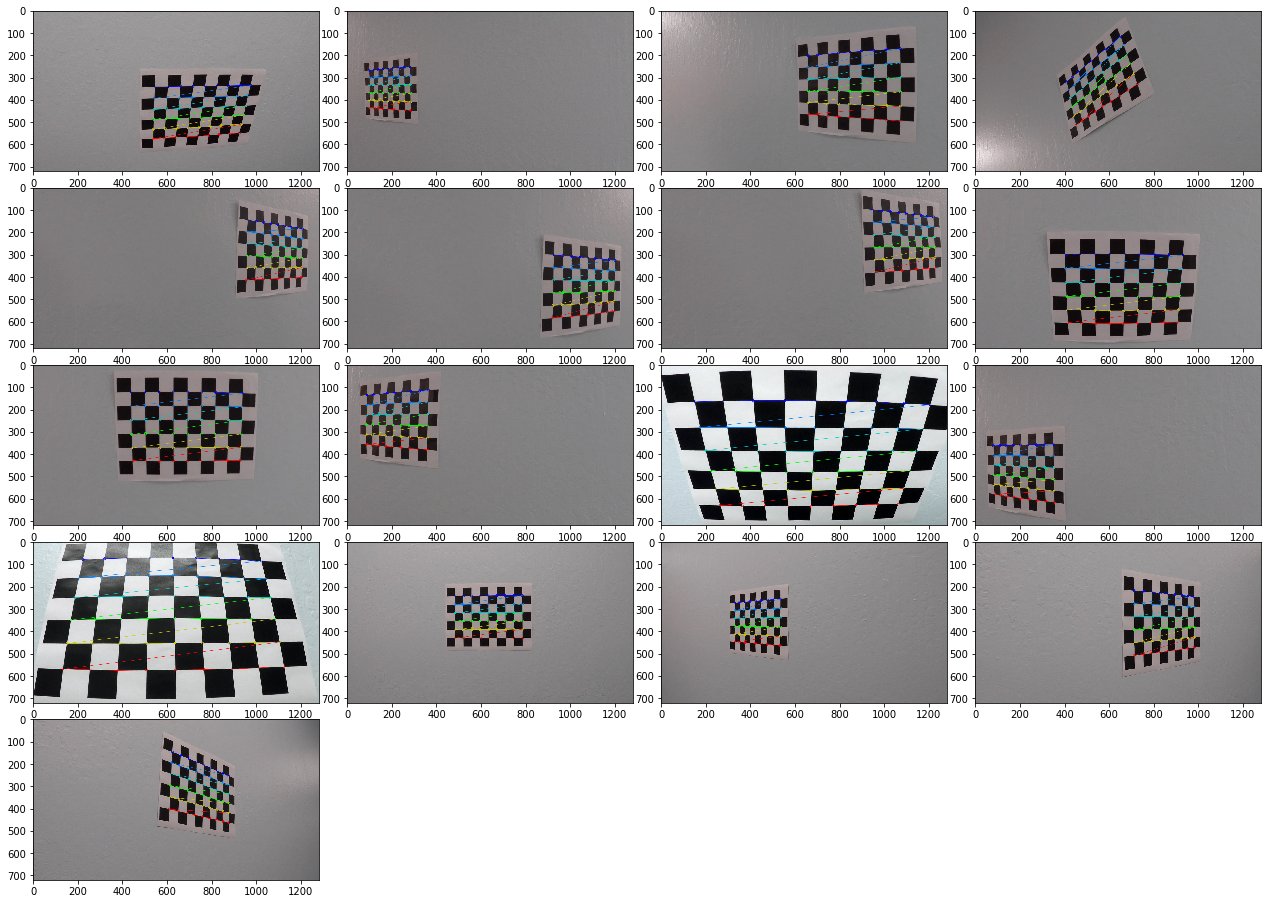

In [3]:
from matplotlib import gridspec
def chessboard_imgshow(images):
    fig = plt.figure(figsize=(22,16))
    gs = gridspec.GridSpec(5, 4, wspace=0.1, hspace=0.1)
    for i in range(len(images)):
        plt.subplot(gs[i])
        plt.imshow(images[i])
    #fig.savefig('./output_images/chessboard_cornerfind.png',bbox_inches = 'tight')
chessboard_imgshow(chessboard_imgs)

In [4]:
# calibriate camera using objpoints and imgpoints. output transision matrix
def cal_calibrate(img, objpoints=objpoints, imgpoints=imgpoints):
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    return ret, mtx, dist
ret, mtx, dist = cal_calibrate(cv2.imread('./camera_cal/calibration3.jpg'))

### Distortion Correction

In [5]:
def undistortion(img, mtx=mtx, dist=dist):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

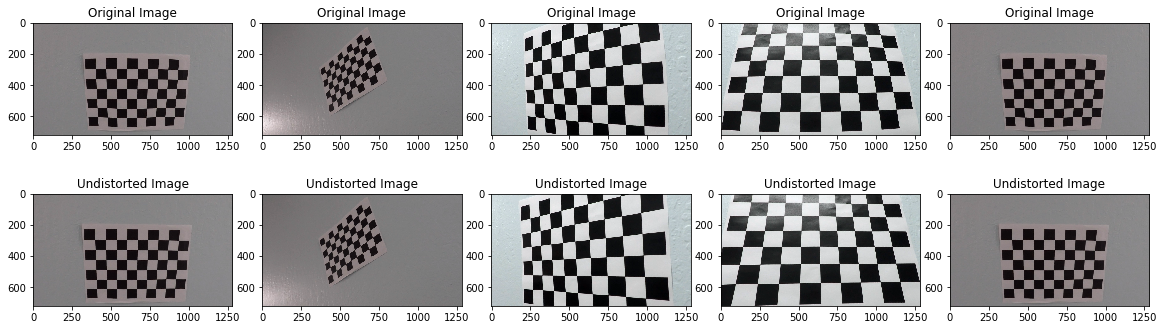

In [6]:
def undistort_chessboard_show(img_dir, objpoints, imgpoints):
    imgs = np.random.choice(os.listdir(img_dir),size=5)
    images = []
    dsts = []
    for i in imgs:
        img = cv2.imread(img_dir+i)
        dst = undistortion(img)
        images.append(img)
        dsts.append(dst)
    fig = plt.figure(figsize=(20,6))
    gs = gridspec.GridSpec(2, 5, wspace=0.15, hspace=0.1)
    for i in range(len(images)):
        plt.subplot(gs[int(i/5), i%5])
        plt.title('Original Image')
        plt.imshow(images[i])
        plt.subplot(gs[int(i/5)+1, i%5])
        plt.title('Undistorted Image')
        plt.imshow(dsts[i])
    #fig.savefig('./output_images/undistort_effect.png',bbox_inches = 'tight')
undistort_chessboard_show('./camera_cal/', objpoints, imgpoints)

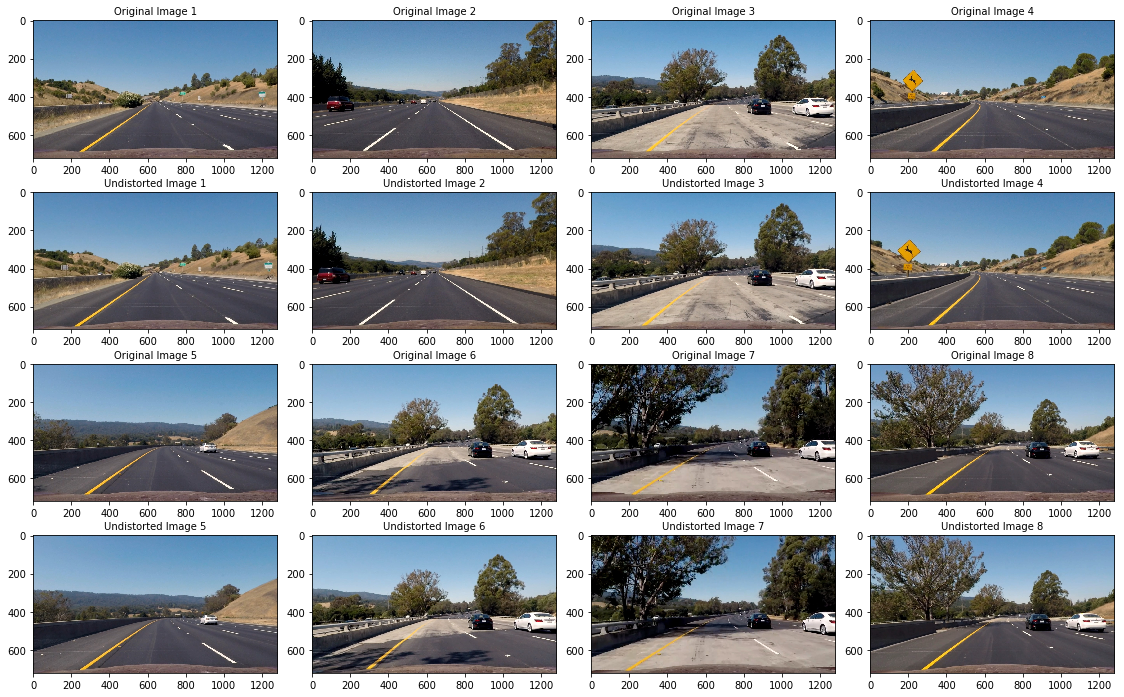

In [7]:
# test image
def undistort_show(img_dir):
    imgs = glob.glob(img_dir)
    images = []
    dsts = []
    for i in imgs:
        img = cv2.imread(i)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        dst = undistortion(img)
        images.append(img)
        dsts.append(dst)
    fig = plt.figure(figsize=(20,12))
    gs = gridspec.GridSpec(4, 4, wspace=0, hspace=0.25)
    for i in range(len(images)):
        plt.subplot(gs[2*int(i/4), i%4])
        plt.title('Original Image {}'.format(i+1),fontsize=10)
        plt.imshow(images[i])
        #plt.axis('off')
        plt.subplot(gs[2*int(i/4)+1, i%4])
        plt.title('Undistorted Image {}'.format(i+1),fontsize=10)
        plt.imshow(dsts[i])
        #plt.axis('off')
    #fig.savefig('./output_images/undistort_test.png',bbox_inches = 'tight')
undistort_show('test_images/*.jpg')

### Color transforms, gradients, etc

* I will first clip some sample frames from the 3 given video with differenct road type and narual environment to adjust threshold parameter effectively and robust.

---

My approach contains the following steps:

1. Abs Sobel threshold on 'x' direction
2. Gradient direction: Avoid bridge edges which are more flat than the lane edges.
3. Grayscale intensity filter: Conditional change threshold for S, L, R, G channel based on the lightness. 
    1. HLS image color threshold for yellow lane: S channel for yellow lane detection, L channel for brightness adaptive.
    2. RGB image color threshold for white lane: R and G channel used for enhancing white lane detection.
6. ROI Mask
7. Remove small object: Denoise 

---

In [8]:

from ipywidgets import interact, interactive, fixed
from skimage import morphology

In [9]:
# random generate frames from challenge video
def random_select_clips(video_path):
    video_cap = cv2.VideoCapture(video_path)
    num_frames = video_cap.get(cv2.CAP_PROP_FRAME_COUNT)
    fps = video_cap.get(cv2.CAP_PROP_FPS)
    total_sec = int(num_frames/fps)
    random_frames = random.sample(range(1,total_sec), 3)
    for i in random_frames:
        video_cap.set(cv2.CAP_PROP_POS_MSEC,i*1000)
        success,image = video_cap.read()
        if success:
            cv2.imwrite('test_images/fit_thresh/{}_{}.jpg'.format(video_path.split('_')[0], i), image)
#random_select_clips('challenge_video.mp4')
#random_select_clips('harder_challenge_video.mp4')

In [10]:
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', thresh=(0,255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

In [11]:
# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output

In [12]:
def gray_intensity_filter(undistorted_img):
    img_gray = cv2.cvtColor(undistorted_img, cv2.COLOR_RGB2GRAY)
    hist_mean = np.mean(img_gray.flatten())
    return hist_mean

In [13]:
def hls_S(img, thresh=(100, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    sbinary = np.zeros_like(S)
    sbinary[(S > thresh[0]) & (S <= thresh[1])] = 1
    return sbinary

In [14]:
def hls_L(img, thresh=(100, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    L = hls[:,:,1]
    Lbinary = np.zeros_like(L)
    Lbinary[(L > thresh[0]) & (L <= thresh[1])] = 1
    return Lbinary

In [15]:
def rgb_RG(img, thresh = (200, 255)):
    R = img[:,:,0]
    G = img[:,:,1]
    rgbinary = np.zeros_like(R)
    rgbinary[(R > thresh[0]) & (G > thresh[0])] = 1
    return rgbinary

In [16]:
def roi_mask(combined_input):
    height,width = combined_input.shape
    mask = np.zeros_like(combined_input)
    vertices = np.array([[100,700],[500,450],[800,450],[1250,700]])
    cv2.fillPoly(mask,[vertices],1)
    combined_res = cv2.bitwise_and(combined_input,mask)
    return combined_res

In [17]:
def threshold_pipeline(undistort_img):
    # sobel threshold
    img_sobel = abs_sobel_thresh(undistort_img,'x', thresh=(10,200))
    # direction threshold
    img_dir = dir_threshold(undistort_img, thresh=(0.7, 1.3))
    # sobel and direction combine
    sobel_dir_combined = ((img_sobel==1) & (img_dir==1))
    # intensity Filter
    hist_mean = gray_intensity_filter(undistort_img)
    if hist_mean <= 65:
        img_sc = hls_S(undistort_img, thresh=(50, 255))
        img_rg = rgb_RG(undistort_img, thresh = (60, 255))
        img_l = hls_L(undistort_img, thresh = (60, 255))
        combined = (img_l & img_rg) & (img_sc | sobel_dir_combined)
    elif hist_mean <= 85:
        img_sc = hls_S(undistort_img, thresh=(80, 255))
        img_rg = rgb_RG(undistort_img, thresh = (80, 255))
        img_l = hls_L(undistort_img, thresh = (80, 255))
        combined = (img_l & img_rg) & (img_sc | sobel_dir_combined)
    else:
        # S channel threshold
        img_sc = hls_S(undistort_img, thresh=(100, 255))
        # rg channel threshold
        img_rg = rgb_RG(undistort_img, thresh = (140, 255))
        # L channel threshold
        img_l = hls_L(undistort_img, thresh = (130, 255))
        # conditional combine binary image
        combined = (img_l & img_rg) & (img_sc | sobel_dir_combined)
    # ROI mask
    combined_res = roi_mask(combined)
    # Denoise remove small objects 
    combined_res = morphology.remove_small_objects(combined_res.astype('bool'),min_size=30,connectivity=2)
    combined_res = np.float32(combined_res)
    return combined_res

In [48]:
imgs = glob.glob('test_images/fit_thresh/*.jpg')
@interact
def threshold_pipeline_visualization(i:(0,len(imgs)-1)=13):
    img = mpimg.imread(imgs[i])
    undistort_img = undistortion(img)
    # sobel threshold
    img_sobel = abs_sobel_thresh(undistort_img,'x', thresh=(10,200))
    # direction threshold
    img_dir = dir_threshold(undistort_img, thresh=(0.7, 1.3))
    # sobel and direction combine
    sobel_dir_combined = ((img_sobel==1) & (img_dir==1))
    # intensity Filter
    hist_mean = gray_intensity_filter(undistort_img)
    if hist_mean <= 65:
        # S channel threshold
        img_sc = hls_S(undistort_img, thresh=(50, 255))
        # rg channel threshold
        img_rg = rgb_RG(undistort_img, thresh = (60, 255))
        # L channel threshold
        img_l = hls_L(undistort_img, thresh = (60, 255))
        # conditional combine binary image
        combined = (img_l & img_rg) & (img_sc | sobel_dir_combined)
    elif hist_mean <= 85:
        # S channel threshold
        img_sc = hls_S(undistort_img, thresh=(80, 255))
        # rg channel threshold
        img_rg = rgb_RG(undistort_img, thresh = (80, 255))
        # L channel threshold
        img_l = hls_L(undistort_img, thresh = (80, 255))
        # conditional combine binary image
        combined = (img_l & img_rg) & (img_sc | sobel_dir_combined)
    else:
        # S channel threshold
        img_sc = hls_S(undistort_img, thresh=(100, 255))
        # rg channel threshold
        img_rg = rgb_RG(undistort_img, thresh = (140, 255))
        # L channel threshold
        img_l = hls_L(undistort_img, thresh = (130, 255))
        # conditional combine binary image
        combined = (img_l & img_rg) & (img_sc | sobel_dir_combined)
    # ROI mask
    combined_res = roi_mask(combined)
    # Denoise remove small objects 
    combined_res = morphology.remove_small_objects(combined_res.astype('bool'),min_size=30,connectivity=2)
    combined_res = np.float32(combined_res)
    # plot show 
    fig = plt.figure(figsize=(18,8))
    gs = gridspec.GridSpec(2, 3, wspace=0.1, hspace=0)
    plt.subplot(gs[0])
    plt.title('Undistort Image')
    plt.imshow(undistort_img)
    plt.subplot(gs[1])
    plt.title('sobel_dir_combined')
    plt.imshow(sobel_dir_combined, cmap='gray')
    plt.subplot(gs[2])
    plt.title('S Image')
    plt.imshow(img_sc, cmap='gray')
    plt.subplot(gs[3])
    plt.title('RG Image')
    plt.imshow(img_rg, cmap='gray')
    plt.subplot(gs[4])
    plt.title('L Image')
    plt.imshow(img_l, cmap='gray')
    plt.subplot(gs[5])
    plt.title('Mask Combined')
    plt.imshow(combined_res, cmap='gray')
    fig.savefig('output_images/threshold_determination.png',bbox_inches = 'tight')

interactive(children=(IntSlider(value=13, description='i', max=19), Output()), _dom_classes=('widget-interact'…

In [19]:
def perspective_transformation(img):
    img_size = (img.shape[1],img.shape[0])
    src = np.float32([[280,690],[570, 470],[700, 470],[1030, 690]])
    dst = np.float32([[340,720],[320, 0],[960, 0],[1000, 720]])
    # transformation matrix
    M = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)
    # warpPerspective
    warped = cv2.warpPerspective(img, M, img_size, flags = cv2.INTER_LINEAR)
    #warped = np.int32(warped.round())
    return warped, M_inv

In [20]:
imgs = glob.glob('test_images/fit_thresh/*.jpg')
@interact
def bird_view_visual(i:(0,len(imgs)-1)=13):
    img = mpimg.imread(imgs[i])
    # polyline
    image = undistortion(img)
    src = np.int32([[250,690],[570, 470],[700, 470],[1110, 690]])
    src = src.reshape((-1,1,2))
    poly_img = image.copy()
    cv2.polylines(poly_img,[src],True,(0,255,0), thickness=5)
    # warped image
    conbined_res = threshold_pipeline(image)
    warped, M_inv = perspective_transformation(conbined_res)
    # figure show
    fig = plt.figure(figsize=(18,8))
    gs = gridspec.GridSpec(1, 3, wspace=0.1, hspace=0)
    plt.subplot(gs[0])
    plt.title('Original Image')
    plt.imshow(poly_img)
    plt.subplot(gs[1])
    plt.title('Combined Image')
    plt.imshow(conbined_res, cmap='gray')
    plt.subplot(gs[2])
    plt.title('Warped Image')
    plt.imshow(warped, cmap='gray')
    #fig.savefig('output_images/perspective_trans.png',bbox_inches = 'tight')

interactive(children=(IntSlider(value=13, description='i', max=19), Output()), _dom_classes=('widget-interact'…

### Lane Pixel Identification

In [21]:
def lane_hist(warped_img):
    hist = np.sum(warped_img[int(warped_img.shape[0]*0.56):,:], axis=0)
    return hist

In [22]:
imgs = glob.glob('test_images/fit_thresh/*.jpg')
@interact
def bird_view_visual(i:(0,len(imgs)-1)=14):
    img = mpimg.imread(imgs[i])
    image = undistortion(img)
    conbined_res = threshold_pipeline(image)
    warped, M_inv = perspective_transformation(conbined_res)
    histogram = lane_hist(warped)
    fig = plt.figure(figsize=(8,12))
    gs = gridspec.GridSpec(2, 1)
    gs.update(wspace=0.0, hspace=0.1)
    ax0 = plt.subplot(gs[0])
    ax0.set_title('Warped Image')
    ax0.imshow(warped, cmap='gray')
    ax0.set_xlim(0, 1280)
    ax1 = plt.subplot(gs[1])
    ax1.set_title('histogram Image')
    ax1.plot(histogram)
    ax1.set_xlim(0, 1280)
    #fig.savefig('output_images/hist.png',bbox_inches = 'tight')

interactive(children=(IntSlider(value=14, description='i', max=19), Output()), _dom_classes=('widget-interact'…

### Sliding Window 

In [23]:
imgs = glob.glob('test_images/fit_thresh/*.jpg')
@interact
def sliding_window_show(i:(0,len(imgs)-1)=17):
    img = mpimg.imread(imgs[i])
    image = undistortion(img)
    conbined_res = threshold_pipeline(image)
    warped, M_inv = perspective_transformation(conbined_res)
    histogram = lane_hist(warped)
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 50

    out_img = np.dstack((warped, warped, warped))*255

    # Step through the windows one by one
    left_lane_inds = []
    right_lane_inds = []
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped.shape[0] - (window+1)*window_height
        win_y_high = warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    out_img = np.int32(out_img)
    plt.figure(figsize=(12,6))
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    #fig.savefig('output_images/sliding_window.png',bbox_inches = 'tight')

interactive(children=(IntSlider(value=17, description='i', max=19), Output()), _dom_classes=('widget-interact'…

In [24]:
def sliding_window_search(warped):
    # create new img
    out_img = np.dstack((warped, warped, warped))*255
    # hist
    histogram = lane_hist(warped)
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Step through the windows one by one
    left_lane_inds = []
    right_lane_inds = []
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped.shape[0] - (window+1)*window_height
        win_y_high = warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    return left_fitx, right_fitx, left_fit,right_fit

### Lane detection using previous frame

In [25]:
def previous_polyfit_search(warped_res, left_fit, right_fit):
    # Now I know where is the lane
    nonzero = warped_res.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 120
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped_res.shape[0]-1, warped_res.shape[0] )
    left_fitx_new = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx_new = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((warped_res, warped_res, warped_res))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    return left_fitx_new, right_fitx_new, left_fit, right_fit

In [26]:
imgs = glob.glob('test_images/fit_thresh/*.jpg')
@interact
def previous_polyfit_show(i:(0,len(imgs)-1)=14):
    img = mpimg.imread(imgs[i])
    image = undistortion(img)
    conbined_res = threshold_pipeline(image)
    warped, M_inv = perspective_transformation(conbined_res)
    histogram = lane_hist(warped)
    # Sliding window
    left_fitx, right_fitx, left_fit,right_fit = sliding_window_search(warped)
    
    # Now I know where is the lane
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((warped, warped, warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))

    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int32([left_line_pts]), (0,255,0))
    cv2.fillPoly(window_img, np.int32([right_line_pts]), (0,255,0))
    res = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    res = np.int32(res)
    fig = plt.figure(figsize=(12,6))
    plt.imshow(res)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
    #fig.savefig('output_images/previous_find.png',bbox_inches = 'tight')

interactive(children=(IntSlider(value=14, description='i', max=19), Output()), _dom_classes=('widget-interact'…

### Curvature and vehicle position

In [27]:
def radius_of_curvature(left_fitx, right_fitx):
    ploty = np.linspace(0, 719, 720)
    y_eval = np.max(ploty)
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    curverad = np.array([left_curverad,right_curverad]).mean()
    
    car_position = 1280/2
    lane_center_position = (left_fitx[719] + right_fitx[719]) / 2
    center_offset = xm_per_pix * (car_position - lane_center_position) 
    return curverad, center_offset, left_curverad, right_curverad

### Project on original image
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [28]:
def project_on_image(undistorted_image, conbined_res, warped, M_inv, left_fit, right_fit, curverad, center_offset):
    out_original = np.copy(undistorted_image)
    img_size = (undistorted_image.shape[1], undistorted_image.shape[0])
    # Create an image to draw the lines on
    out_warped = np.zeros_like(warped).astype(np.uint8)
    out_warped = np.dstack((warped, warped, warped))
    # ploty
    ploty = np.linspace(0, img_size[1]-1, img_size[1])
    # calculate lane coordination
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    left_lane = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    right_lane = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((left_lane, right_lane))
    # Draw the lane
    cv2.fillPoly(out_warped, np.int32([pts]), (0,255,0))
    cv2.polylines(out_warped, np.int32([left_lane]), False, color=(255,0,255), thickness=15)
    cv2.polylines(out_warped, np.int32([right_lane]), False, color=(0,255,255), thickness=15)
    out_warped = out_warped.astype(np.uint8)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    unwarped = cv2.warpPerspective(out_warped, M_inv, img_size, flags=cv2.INTER_LINEAR)
    # Combine the result with the original image
    final_output = cv2.addWeighted(out_original, 1, unwarped, 0.5, 0)
    final_output = final_output.astype(np.uint8)
    
    # radius and position attach
    if center_offset > 0:
        direction = 'Right'
    else:
        direction = 'Left'
    text_rad = 'Estimated Curvature: ' + '{:.3f}'.format(curverad) + 'm'
    text_pos = 'Estimated Offset: ' + '{:.3f}'.format(abs(center_offset)) + 'm ' + direction
    #font = cv2.FONT_HERSHEY_SIMPLEXCV_FONT_HERSHEY_DUPLEX 
    cv2.putText(final_output, text_rad, (40,70), cv2.FONT_HERSHEY_SIMPLEX , 1.2, (255,255,255), 2, cv2.LINE_AA)
    cv2.putText(final_output, text_pos, (40,120), cv2.FONT_HERSHEY_SIMPLEX , 1.2, (255,255,255), 2, cv2.LINE_AA)
    
    conbined_ = np.copy(conbined_res)
    conbined_ = np.dstack((conbined_, conbined_, conbined_))*255

    warped_ = np.copy(warped)
    warped_ = np.dstack((warped_, warped_, warped_))*255

    mixed_screen = np.zeros((1080, 1280,3), dtype=np.uint8)
    mixed_screen[0:720, 0:1280] = final_output
    mixed_screen[720:1080, 0:640] = cv2.resize(conbined_, (640,360), interpolation=cv2.INTER_AREA) 
    mixed_screen[720:1080, 640:1280] = cv2.resize(warped_, (640,360), interpolation=cv2.INTER_AREA)
    
    return mixed_screen

In [29]:
imgs = glob.glob('test_images/fit_thresh/*.jpg')
@interact
def project_on_image_show(i:(0,len(imgs)-1)=8):
    img = mpimg.imread(imgs[i])
    image = undistortion(img)
    conbined_res = threshold_pipeline(image)
    warped, M_inv = perspective_transformation(conbined_res)
    histogram = lane_hist(warped)
    left_fitx, right_fitx, left_fit, right_fit = sliding_window_search(warped)
    left_fitx_new, right_fitx_new, left_fit, right_fit = previous_polyfit_search(warped, left_fit, right_fit)
    curverad, center_offset, left_curve, right_curve = radius_of_curvature(left_fitx_new, right_fitx_new)
    
    mixed_screen = project_on_image(image, conbined_res, warped, M_inv, left_fit, right_fit,curverad,center_offset)

    plt.figure(figsize=(12,10))
    plt.imshow(mixed_screen)
    #plt.savefig('output_images/project_back.png',bbox_inches = 'tight')

interactive(children=(IntSlider(value=8, description='i', max=19), Output()), _dom_classes=('widget-interact',…

In [30]:
def img_pipeline(img, mtx=mtx, dist=dist):
    undistort_img = undistortion(img, mtx=mtx, dist=dist)
    combined_threshold = threshold_pipeline(undistort_img)
    warped, M_inv = perspective_transformation(combined_threshold)
    return undistort_img, combined_threshold, warped, M_inv

In [31]:
def mixed_pipeline(img):
    undistort_img, combined_threshold, warped, M_inv = img_pipeline(img)
    left_fitx, right_fitx, left_fit, right_fit = sliding_window_search(warped)
    curverad, center_offset, left_curve, right_curve = radius_of_curvature(left_fitx, right_fitx)
    mixed_screen = project_on_image(undistort_img,combined_threshold,warped,M_inv,left_fit,right_fit,curverad,center_offset)
    return mixed_screen

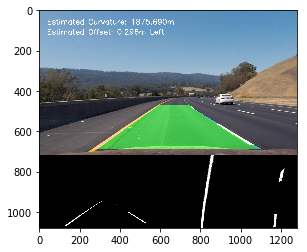

In [32]:
aa = imgs[16]
bb = mpimg.imread(aa)
mixed_screen1 = mixed_pipeline(bb)
plt.imshow(mixed_screen1)

In [33]:
aa = imgs[15]
bb = mpimg.imread(aa)
undistort_img, combined_threshold, warped, M_inv = img_pipeline(bb)
left_fitx, right_fitx, left_fit, right_fit = sliding_window_search(warped)
curverad, center_offset, left_curve, right_curve = radius_of_curvature(left_fitx, right_fitx)

In [34]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [35]:
def update_parameter(left_fitx,right_fitx,left_fit,right_fit):
    left_lane.best_fit = left_fit
    right_lane.best_fit = right_fit
    left_lane.allx = left_fitx
    right_lane.allx = right_fitx

In [36]:
# For some bad frames which are no lane detected
def land_detected(warped_input):
    histogram = lane_hist(warped_input)
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    if (leftx_base < 50) or (rightx_base<=midpoint):
        return False
    else:
        return True

In [37]:
def sanity_check(left_fitx_new, right_fitx_new, left_curve, right_curve, prev_mean_dis):#, prev_mean_dis):
    mean_dis_lane = (right_fitx_new-left_fitx_new).mean()
    if (mean_dis_lane < 0.7*prev_mean_dis) | (mean_dis_lane > 1.3*prev_mean_dis):
        return False
    else:
        return True

In [38]:
def process_pipeline(video_img):
    # variable initialization
    global frames_used
    global bad_frames
    global no_lane_found
    frames_used += 1
    runing_window = 12
    # image processing
    undistort_img, combined_threshold, warped, M_inv = img_pipeline(video_img)
    if left_lane.detected == False and right_lane.detected == False:
        # start window search
        left_fitx, right_fitx, left_fit, right_fit = sliding_window_search(warped)
        curverad, center_offset, left_curve, right_curve = radius_of_curvature(left_fitx, right_fitx)
        # update the existing class variables
        left_lane.recent_xfitted.append(left_fit)
        right_lane.recent_xfitted.append(right_fit)
        left_lane.radius_of_curvature = left_curve
        right_lane.radius_of_curvature = right_curve
        left_lane.line_base_pos = center_offset
        update_parameter(left_fitx, right_fitx, left_fit, right_fit)
        # Lane found now, set the detected status to True
        left_lane.detected = True
        right_lane.detected = True
    else:
        if land_detected(warped):
            #if bad_frames <= 3:
            #left_lane.best_fit = np.mean(left_lane.recent_xfitted[-runing_window:],axis=0)
            #right_lane.best_fit = np.mean(right_lane.recent_xfitted[-runing_window:],axis=0)
            # Using previous found line to find new line (avoid sliding window search if previous lane have been detected)
            prev_mean_dis = (right_lane.allx - left_lane.allx).mean()
            left_fitx_new, right_fitx_new, left_fit_new, right_fit_new = previous_polyfit_search(warped,left_lane.best_fit,right_lane.best_fit)
            curverad, center_offset, left_curve, right_curve = radius_of_curvature(left_fitx_new, right_fitx_new)
            # Sanity Checking
            if sanity_check(left_fitx_new, right_fitx_new, left_curve, right_curve, prev_mean_dis) == True:
                # update parameters and append fit from good frames to recent_xfitted
                left_lane.recent_xfitted.append(left_fit_new)
                right_lane.recent_xfitted.append(right_fit_new)
                left_lane.radius_of_curvature = left_curve
                right_lane.radius_of_curvature = right_curve
                left_lane.line_base_pos = center_offset
                update_parameter(left_fitx_new, right_fitx_new, left_fit_new, right_fit_new)
                left_lane.best_fit = np.mean(left_lane.recent_xfitted[-runing_window:],axis=0)
                right_lane.best_fit = np.mean(right_lane.recent_xfitted[-runing_window:],axis=0)
            else:
                bad_frames += 1
        else:
            no_lane_found += 1
            
    curverad = (left_lane.radius_of_curvature+right_lane.radius_of_curvature)/2           
    mixed_screen = project_on_image(undistort_img,combined_threshold,warped,M_inv, left_lane.best_fit, right_lane.best_fit, curverad, left_lane.line_base_pos)     
    return mixed_screen

In [40]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
# Set up lines for left and right
frames_used = 0
left_lane = Line()
right_lane = Line()
bad_frames = 0
no_lane_found = 0
video_output = 'output_video/project_video_res.mp4'
clip1 = VideoFileClip('./project_video.mp4')
video_clip = clip1.fl_image(process_pipeline) #NOTE: this function expects color images!!
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_video/project_video_res.mp4
[MoviePy] Writing video output_video/project_video_res.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [03:55<00:00,  5.35it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video/project_video_res.mp4 

Wall time: 3min 56s


### Challenge video

In [39]:
def lane_hist(warped_img):
    hist = np.sum(warped_img[int(warped_img.shape[0]*0.56):,:], axis=0)
    return hist

In [40]:
# For some bad frames which are no lane detected
def land_detected(warped_input):
    histogram = lane_hist(warped_input)
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    if (leftx_base < 150) or (rightx_base<=midpoint):
        return False
    else:
        return True

In [41]:
def sanity_check(left_fitx_new, right_fitx_new, left_curve, right_curve, prev_mean_dis):#, prev_mean_dis):
    mean_dis_lane = (right_fitx_new-left_fitx_new).mean()
    if (mean_dis_lane < 0.7*prev_mean_dis) | (mean_dis_lane > 1.3*prev_mean_dis):
        return False
    elif abs(right_curve-left_curve) > 1000:
        return False
    else:
        return True

In [42]:
def process_pipeline_challenge(video_img):
    # variable initialization
    global frames_used
    global bad_frames
    global no_lane_found
    frames_used += 1
    runing_window = 6
    # image processing
    undistort_img, combined_threshold, warped, M_inv = img_pipeline(video_img)
    if left_lane.detected == False and right_lane.detected == False:
        # start window search
        left_fitx, right_fitx, left_fit, right_fit = sliding_window_search(warped)
        curverad, center_offset, left_curve, right_curve = radius_of_curvature(left_fitx, right_fitx)
        # update the existing class variables
        left_lane.recent_xfitted.append(left_fit)
        right_lane.recent_xfitted.append(right_fit)
        left_lane.radius_of_curvature = left_curve
        right_lane.radius_of_curvature = right_curve
        left_lane.line_base_pos = center_offset
        update_parameter(left_fitx, right_fitx, left_fit, right_fit)
        # Lane found now, set the detected status to True
        left_lane.detected = True
        right_lane.detected = True
    else:
        if land_detected(warped):
            #if bad_frames <= 3:
            #left_lane.best_fit = np.mean(left_lane.recent_xfitted[-runing_window:],axis=0)
            #right_lane.best_fit = np.mean(right_lane.recent_xfitted[-runing_window:],axis=0)
            # Using previous found line to find new line (avoid sliding window search if previous lane have been detected)
            prev_mean_dis = (right_lane.allx - left_lane.allx).mean()
            left_fitx_new, right_fitx_new, left_fit_new, right_fit_new = previous_polyfit_search(warped,left_lane.best_fit,right_lane.best_fit)
            curverad, center_offset, left_curve, right_curve = radius_of_curvature(left_fitx_new, right_fitx_new)
            if bad_frames < 10:
                # Sanity Checking
                if sanity_check(left_fitx_new, right_fitx_new, left_curve, right_curve, prev_mean_dis) == True:
                    # update parameters and append fit from good frames to recent_xfitted
                    left_lane.recent_xfitted.append(left_fit_new)
                    right_lane.recent_xfitted.append(right_fit_new)
                    left_lane.radius_of_curvature = left_curve
                    right_lane.radius_of_curvature = right_curve
                    left_lane.line_base_pos = center_offset
                    update_parameter(left_fitx_new, right_fitx_new, left_fit_new, right_fit_new)
                    left_lane.best_fit = np.mean(left_lane.recent_xfitted[-runing_window:],axis=0)
                    right_lane.best_fit = np.mean(right_lane.recent_xfitted[-runing_window:],axis=0)
                else:
                    bad_frames += 1
            else:
                left_lane.detected = False
                right_lane.detected = False
                bad_frames = 0
        else:
            no_lane_found += 1
            
    curverad = (left_lane.radius_of_curvature+right_lane.radius_of_curvature)/2           
    mixed_screen = project_on_image(undistort_img,combined_threshold,warped,M_inv, left_lane.best_fit, right_lane.best_fit, curverad, left_lane.line_base_pos)     
    return mixed_screen

In [43]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
# Set up lines for left and right
frames_used = 0
left_lane = Line()
right_lane = Line()
bad_frames = 0
no_lane_found = 0
video_output = 'output_video/challenge_video_res.mp4'
clip1 = VideoFileClip('./challenge_video.mp4')
video_clip = clip1.fl_image(process_pipeline_challenge) #NOTE: this function expects color images!!
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_video/challenge_video_res.mp4
[MoviePy] Writing video output_video/challenge_video_res.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [01:30<00:00,  5.34it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video/challenge_video_res.mp4 

Wall time: 1min 31s


### harder video

In [44]:
# For some bad frames which are no lane detected
def land_detected(warped_input):
    histogram = lane_hist(warped_input)
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    if (leftx_base < 150) or (rightx_base<=900):
        return False
    else:
        return True

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
# Set up lines for left and right
frames_used = 0
left_lane = Line()
right_lane = Line()
bad_frames = 0
no_lane_found = 0
video_output = 'output_video/harder_challenge_video_res.mp4'
clip1 = VideoFileClip('./harder_challenge_video.mp4')
video_clip = clip1.fl_image(process_pipeline_challenge) #NOTE: this function expects color images!!
%time video_clip.write_videofile(video_output, audio=False)

In [46]:
video_clip.reader.close()
video_clip.audio.reader.close_proc()